In [1]:
import tensorflow as tf
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import cv2
import numpy as np
import random
import math

from helpers import *
from sklearn.model_selection import train_test_split
from unet_model import multi_unet_model, jacard_coef  
from skimage.io import imread, imshow
from tqdm import tqdm
from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image, ImageOps

In [152]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15439505194692693983
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1749391771
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6551215370242927843
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [153]:
print(tf.__version__)
tf.random.set_seed(42) # To load models 
np.random.seed(42)
random.seed(42)

2.10.0


In [154]:
# Make use of GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# with tf.device('/cpu:0'): Force CPU utilization instead of GPU
# This code should run on the GPU, you can see it by uncommenting the code in the previous cell
a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)
print(c)

Num GPUs Available:  1
tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


In [273]:
ROOT_DIRECTORY = 'old_training/'
PATCH_SIZE = 80
NUMBER_IMAGES_TRAINING = 100
TRAIN_PATH_IMAGES = 'old_training/images/'
TRAIN_PATH_GROUNDTRUTH = 'old_training/groundtruth/'
TEST_PATH = 'test_set_images/'

In [268]:
#Read images from repsective 'images' subdirectory
#As all images are of ddifferent size we have 2 options, either resize or crop
#But, some images are too large and some small. Resizing will change the size of real objects.
#Therefore, we will crop them to a nearest size divisible by 256 and then 
#divide all images into patches of 256x256x3. 
image_dataset = []  
position = 0
for path, subdirs, files in os.walk(ROOT_DIRECTORY):
    dirname = path.split("/")[-1]
    if dirname == 'images':   #Find all 'images' directories
        images = os.listdir(path)  #List of all image names in this subdirectory
        for i, image_name in tqdm(enumerate(images), total=NUMBER_IMAGES_TRAINING):
            if i+1 > NUMBER_IMAGES_TRAINING:
                break
            if image_name.endswith(".png"):   #Only read jpg images...
               
                image = cv2.imread(path+"/"+image_name, 1)  #Read each image as BGR
                SIZE_X = (image.shape[1]//PATCH_SIZE)*PATCH_SIZE #Nearest size divisible by our patch size
                SIZE_Y = (image.shape[0]//PATCH_SIZE)*PATCH_SIZE #Nearest size divisible by our patch size
                image = Image.fromarray(image)
                image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                image = np.array(image) 
                #Extract patches from each image
                #print("Now patchifying image:", path+"/"+image_name)
                patches_img = patchify(image, (PATCH_SIZE, PATCH_SIZE, 3), step=PATCH_SIZE)  #Step=256 for 256 patches means no overlap
        
                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):
                        
                        single_patch_img = patches_img[i,j,:,:]
                        
                        #Use minmaxscaler instead of just dividing by 255. 
                        
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. 
                        single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds. 
                        image_dataset.append(single_patch_img)

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 134.77it/s]


In [274]:
for path, subdirs, files in os.walk(ROOT_DIRECTORY):
    dirname = path.split("/")[-1]
    if dirname == 'images':   #Find all 'images' directories
        images = os.listdir(path)  #List of all image names in this subdirectory
        for i, image_name in tqdm(enumerate(images), total=NUMBER_IMAGES_TRAINING):
            if i+1 > NUMBER_IMAGES_TRAINING:
                break
            if image_name.endswith(".png"):   #Only read jpg images...
                image = cv2.imread(path+"/"+image_name, 1)
                img_train_rotations = get_rotations_0_90_180_270(image)
                for i in range(1,4):
                    cv2.imwrite(os.path.join(TRAIN_PATH_IMAGES , image_name[:-4] + '_' + str(i) + ".png"), img_train_rotations[i])

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.30it/s]


In [270]:
mask_dataset = []  
position = 0
for path, subdirs, files in os.walk(ROOT_DIRECTORY):
    #print(path)  
    dirname = path.split("/")[-1]
    if dirname == 'groundtruth':   #Find all 'images' directories
        masks = os.listdir(path)  #List of all image names in this subdirectory
        for i, mask_name in tqdm(enumerate(masks), total=NUMBER_IMAGES_TRAINING):  
            if i+1 > NUMBER_IMAGES_TRAINING:
                break
            if mask_name.endswith(".png"):   #Only read png images... (masks in this dataset)
               
                mask = cv2.imread(path+"/"+mask_name, 1)  #Read each image as Grey (or color but remember to map each color to an integer)
                mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
                SIZE_X = (mask.shape[1]//PATCH_SIZE)*PATCH_SIZE #Nearest size divisible by our patch size
                SIZE_Y = (mask.shape[0]//PATCH_SIZE)*PATCH_SIZE #Nearest size divisible by our patch size
                mask = Image.fromarray(mask)
                mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #mask = mask.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                mask = np.array(mask)  
       
                #Extract patches from each image
                #print("Now patchifying mask:", path+"/"+mask_name)
                patches_mask = patchify(mask, (PATCH_SIZE, PATCH_SIZE, 1), step=PATCH_SIZE)  #Step=256 for 256 patches means no overlap
        
                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):
                        
                        single_patch_mask = patches_mask[i,j,:,:]
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. #No need to scale masks, but you can do it if you want
                        single_patch_mask = single_patch_mask[0] #Drop the extra unecessary dimension that patchify adds.   
                        mask_dataset.append(single_patch_mask) 

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 289.03it/s]


In [275]:
for path, subdirs, files in os.walk(ROOT_DIRECTORY):
    dirname = path.split("/")[-1]
    if dirname == 'groundtruth':   #Find all 'images' directories
        images = os.listdir(path)  #List of all image names in this subdirectory
        for i, mask_name in tqdm(enumerate(images), total=NUMBER_IMAGES_TRAINING):
            if i+1 > NUMBER_IMAGES_TRAINING:
                break
            if mask_name.endswith(".png"):   #Only read jpg images...
                image = cv2.imread(path+"/"+mask_name, 1)
                image = image[:, :, 0]
                img_train_rotations = get_rotations_0_90_180_270(image)
                for i in range(1,4):
                    cv2.imwrite(os.path.join(TRAIN_PATH_GROUNDTRUTH , mask_name[:-4] + '_' + str(i) + ".png"), img_train_rotations[i])

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 110.19it/s]


In [234]:
# Test images
test_ids = os.listdir(TEST_PATH)
test_dataset = []
print('Resizing test images') 
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    image = Image.open(path+"/"+ id_+".png")
    new_size_X = math.ceil(image.size[1]/PATCH_SIZE)*PATCH_SIZE
    new_size_Y = math.ceil(image.size[0]/PATCH_SIZE)*PATCH_SIZE
    image = resize_with_padding(image, (new_size_X, new_size_Y))
    image = np.array(image)  #Read each image as BGR
    #print(image.shape)
    SIZE_X = (image.shape[1]//PATCH_SIZE)*PATCH_SIZE #Nearest size divisible by our patch size
    SIZE_Y = (image.shape[0]//PATCH_SIZE)*PATCH_SIZE #Nearest size divisible by our patch size
    image = Image.fromarray(image)
    image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
    #image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
    image = np.array(image) 
    #Extract patches from each image
    #print("Now patchifying image:", path+"/"+image_name)
    patches_img = patchify(image, (PATCH_SIZE, PATCH_SIZE, 3), step=PATCH_SIZE)  #Step=256 for 256 patches means no overlap

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):

            single_patch_img = patches_img[i,j,:,:]

            #Use minmaxscaler instead of just dividing by 255. 
            #single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)

            #single_patch_img = (single_patch_img.astype('float32')) / 255. 
            single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds. 
            test_dataset.append(single_patch_img)

print('Done!')

Resizing test images


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 72.78it/s]

Done!


In [235]:
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset, dtype=np.bool_)
test_dataset = np.array(test_dataset)

In [236]:
print(image_dataset.shape)
print(mask_dataset.shape)
print(test_dataset.shape)

(2500, 80, 80, 3)
(2500, 80, 80, 1)
(3200, 80, 80, 3)


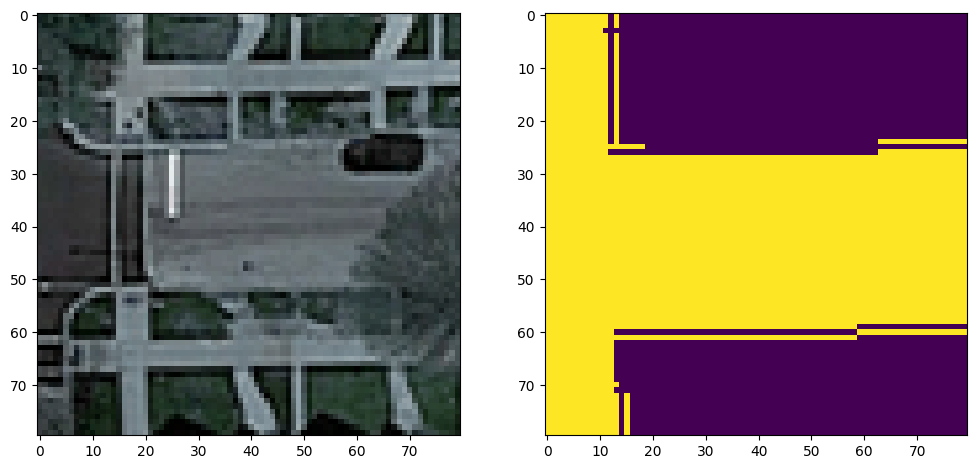

In [237]:
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (PATCH_SIZE, PATCH_SIZE, 3)))
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (PATCH_SIZE, PATCH_SIZE, 1)))
plt.show()

In [239]:
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.10, random_state = 42)

In [240]:
print(X_train.shape)

(2250, 80, 80, 3)


In [241]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

metrics=['accuracy']

def get_model():
    return multi_unet_model(IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 80, 80, 3)]  0           []                               
                                                                                                  
 lambda_3 (Lambda)              (None, 80, 80, 3)    0           ['input_4[0][0]']                
                                                                                                  
 conv2d_57 (Conv2D)             (None, 80, 80, 16)   448         ['lambda_3[0][0]']               
                                                                                                  
 dropout_27 (Dropout)           (None, 80, 80, 16)   0           ['conv2d_57[0][0]']              
                                                                                            

In [242]:
MODEL_NAME = "unet_test_3"
checkpoint_path = "check_points/" + MODEL_NAME + "/"
checkpoint_dir = os.path.dirname(checkpoint_path)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs'),
        tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,verbose=1)]

model.fit(X_train, y_train,
            batch_size = 16, 
            verbose=1, 
            epochs=100, 
            validation_data=(X_test, y_test), 
            shuffle=False,
            callbacks=callbacks)

model.save("models/" + MODEL_NAME + ".h5")

Epoch 1/100
141/141 [==============================] - ETA: 0s - loss: 0.5252 - accuracy: 0.7695
Epoch 1: saving model to check_points/unet_test_3\
141/141 [==============================] - 7s 41ms/step - loss: 0.5252 - accuracy: 0.7695 - val_loss: 0.5118 - val_accuracy: 0.7678
Epoch 2/100
141/141 [==============================] - ETA: 0s - loss: 0.4743 - accuracy: 0.7762
Epoch 2: saving model to check_points/unet_test_3\
141/141 [==============================] - 5s 37ms/step - loss: 0.4743 - accuracy: 0.7762 - val_loss: 0.5202 - val_accuracy: 0.7667
Epoch 3/100
141/141 [==============================] - ETA: 0s - loss: 0.4489 - accuracy: 0.7836
Epoch 3: saving model to check_points/unet_test_3\
141/141 [==============================] - 5s 37ms/step - loss: 0.4489 - accuracy: 0.7836 - val_loss: 0.4795 - val_accuracy: 0.7792
Epoch 4/100
141/141 [==============================] - ETA: 0s - loss: 0.4268 - accuracy: 0.7978
Epoch 4: saving model to check_points/unet_test_3\
141/141 [===

In [ ]:
custom_objects = {"jacard_coef": jacard_coef}
with tf.keras.utils.custom_object_scope(custom_objects):
    model = tf.keras.models.load_model('models/unet_model_1.h5')

In [243]:
preds_train = model.predict(image_dataset[:int(image_dataset.shape[0]*0.9)], verbose=1)
preds_val = model.predict(image_dataset[int(image_dataset.shape[0]*0.9):], verbose=1)
preds_test = model.predict(test_dataset, verbose=1)

 
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

100/100 [==============================] - 2s 16ms/step


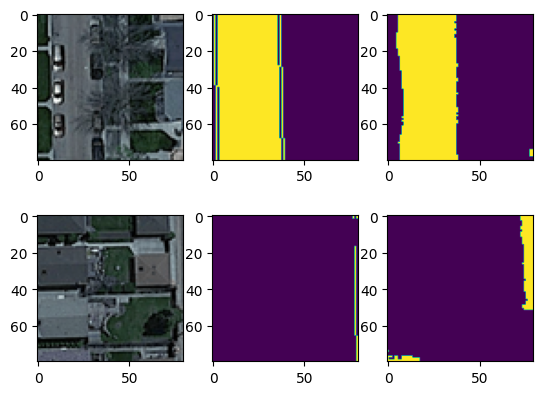

In [205]:
# Perform a sanity check on some random training samples
fig, ax = plt.subplots(2,3)
ix = random.randint(0, len(preds_train_t))
ax[0,0].imshow(image_dataset[ix])
ax[0,1].imshow(np.squeeze(mask_dataset[ix]))
ax[0,2].imshow(np.squeeze(preds_train_t[ix]))

# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
ax[1,0].imshow(image_dataset[int(image_dataset.shape[0]*0.9):][ix])
ax[1,1].imshow(np.squeeze(mask_dataset[int(mask_dataset.shape[0]*0.9):][ix]))
ax[1,2].imshow(np.squeeze(preds_val_t[ix]))
plt.show()

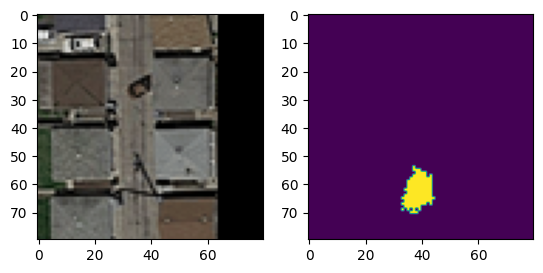

In [258]:
fig, ax = plt.subplots(1,2)
ix = random.randint(0, len(preds_test_t))
ax[0].imshow(test_dataset[ix])
ax[1].imshow(np.squeeze(preds_test_t[ix]))

In [ ]:
submission = []
# The constants with _SIDE mean how many patches fit per image in one dimension (one side)
TEST_IMAGE_LENGTH = 608
PATCHES_PER_IMAGE_SIDE = math.ceil(TEST_IMAGE_LENGTH/PATCH_SIZE)
PATCHES_PER_IMAGE = PATCHES_PER_IMAGE_SIDE**2
SUBIMAGES_PER_PATCH_SIDE = PATCH_SIZE/16
for i, pred in enumerate(preds_test):
    img_id = test_ids[i//PATCHES_PER_IMAGE]
    # Format the image id
    id = img_id.split('_')[1].zfill(3)
    # Make sure the patch size is a multiple of 16 otherwise this line won't work
    preds = split_into_patches(pred, 16)
    for j, img in enumerate(preds):
        # Calculate the index of each subimage (in terms of pixels)
        x = 16*(SUBIMAGES_PER_PATCH_SIDE*((i % PATCHES_PER_IMAGE) % PATCHES_PER_IMAGE_SIDE) + j % SUBIMAGES_PER_PATCH_SIDE)
        y = 16*(SUBIMAGES_PER_PATCH_SIDE*((i % PATCHES_PER_IMAGE) // PATCHES_PER_IMAGE_SIDE) + j // SUBIMAGES_PER_PATCH_SIDE)
        # Don't add the padding predictions
        if x < TEST_IMAGE_LENGTH and y < TEST_IMAGE_LENGTH:
            # For now we calculate the average over all the pixels and check if it's above 0.5
            submission.append((f"{id}_{x:.0f}_{y:.0f}", 1 if img.mean() > 0.5 else 0))
            if img.mean() > 0.5:
                print("Urar")
np.savetxt("predictions.csv", np.asarray(submission), fmt="%s", delimiter=",", newline="\n", header="id,prediction", comments="")

In [43]:
def cv2_clipped_zoom(img, zoom_factor=0):

    """
    Center zoom in/out of the given image and returning an enlarged/shrinked view of 
    the image without changing dimensions
    ------
    Args:
        img : ndarray
            Image array
        zoom_factor : float
            amount of zoom as a ratio [0 to Inf). Default 0.
    ------
    Returns:
        result: ndarray
           numpy ndarray of the same shape of the input img zoomed by the specified factor.          
    """
    if zoom_factor == 0:
        return img


    height, width = img.shape[:2] # It's also the final desired shape
    new_height, new_width = int(height * zoom_factor), int(width * zoom_factor)
    
    ### Crop only the part that will remain in the result (more efficient)
    # Centered bbox of the final desired size in resized (larger/smaller) image coordinates
    y1, x1 = max(0, new_height - height) // 2, max(0, new_width - width) // 2
    y2, x2 = y1 + height, x1 + width
    bbox = np.array([y1,x1,y2,x2])
    # Map back to original image coordinates
    bbox = (bbox / zoom_factor).astype(np.int)
    y1, x1, y2, x2 = bbox
    cropped_img = img[y1:y2, x1:x2]
    
    # Handle padding when downscaling
    resize_height, resize_width = min(new_height, height), min(new_width, width)
    pad_height1, pad_width1 = (height - resize_height) // 2, (width - resize_width) //2
    pad_height2, pad_width2 = (height - resize_height) - pad_height1, (width - resize_width) - pad_width1
    pad_spec = [(pad_height1, pad_height2), (pad_width1, pad_width2)] + [(0,0)] * (img.ndim - 2)
    
    result = cv2.resize(cropped_img, (resize_width, resize_height))
    result = np.pad(result, pad_spec, mode='constant')
    assert result.shape[0] == height and result.shape[1] == width
    return result

C:\Users\Mateo Echeverry\AppData\Local\Temp\ipykernel_1608\1676924905.py:30: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bbox = (bbox / zoom_factor).astype(np.int)


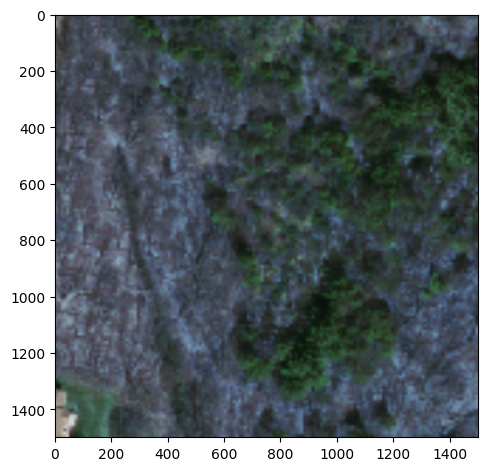

In [54]:
image = cv2.imread("new_satImage_001.png")
new_image = cv2_clipped_zoom(image,10)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(new_image, (1500, 1500, 3)))

In [62]:
hola = "satImage_096.png"
hola[:-4]

'satImage_096'